In [1]:
!nvidia-smi

Thu Dec 31 17:16:12 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import random

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as T
from torchvision.utils import make_grid, save_image
from torchvision.datasets import ImageFolder

from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

%matplotlib inline

In [3]:
# Set random seed for reproducibility
manualSeed = 67
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  67


# Utility Functions

In [4]:
# move to Device

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else: 
        return torch.device('cpu')

device = get_default_device()
device

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
    
    def __len__(self):
        return len(self.dl)



# Denormalize images
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

# Visualization
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.cpu().detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break


def save_samples(index, model, latent_tensors, show=True, verbose=False):
    fake_images = model(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    if verbose:
        print('Saving', fake_fname)
    if show:
        show_images(fake_images)

# Constants

In [5]:
dataset_path = r"/content/celeba"

LATENT_DIMS = 100
BATCH_SIZE = 128
LEARNING_RATE = 0.0002
EPOCHS = 15

IMG_SIZE = 64
IMG_CHANNELS = 3
CAPACITY_G = 64
CAPACITY_D = 64

BETA1 = 0.5
BETA2 = 0.999

real_label = 1.
fake_label = 0.

# Download and Prepare dataset

In [6]:
from google_drive_downloader import GoogleDriveDownloader as gdd

# https://drive.google.com/file/d/1bdL4yJy4UPsB6rg97r75hdQmebiE2EI4/view?usp=sharing


if not os.path.exists("/content/data.zip"):
    gdd.download_file_from_google_drive(file_id='1bdL4yJy4UPsB6rg97r75hdQmebiE2EI4',
                                    dest_path='/content/celeba/data.zip',
                                    showsize=True,
                                    unzip=True)

    !mv /content/celeba/data.zip /content/data.zip

In [7]:
dataset = ImageFolder(root=dataset_path,
                      transform=T.Compose([
                               T.Resize(IMG_SIZE),
                               T.CenterCrop(IMG_SIZE),
                               T.ToTensor(),
                               T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

data_loader = DataLoader(dataset, 
                         BATCH_SIZE,
                         shuffle=True, 
                         pin_memory=True,
                         num_workers=4)

data_loader = DeviceDataLoader(data_loader, device)

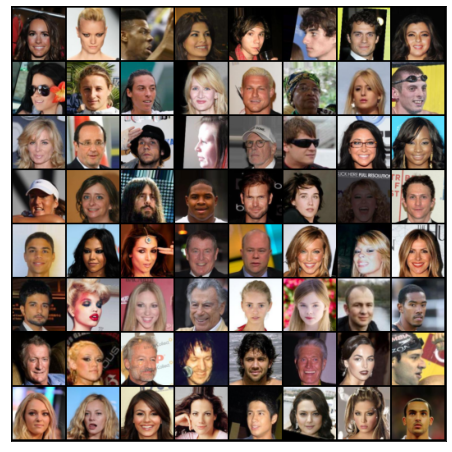

In [8]:
show_batch(data_loader)

In [9]:
len(dataset), len(data_loader)

(202599, 1583)

# Model Design

## Weight Initialization
 
- as mentioned in DCGAN paper


In [10]:
# custom weights initialization called on generator and discriminator

def weights_init(model):
    classname = model.__class__.__name__
    if classname.find('conv') != -1:
        torch.nn.init.normal_(model.weight, 0.0, 0.02)
    elif classname.find('batch_norm') != -1:
        torch.nn.init.normal_(model.weight, 1.0, 0.02)
        torch.nn.init.zeros_(model.bias)

## Generator Network

In [11]:
class Generator(nn.Module):

    def __init__(self):
        super().__init__()
        
        # INPUT: (BATCH_SIZE, LATENT_DIMS, 1, 1)
        
        self.conv_transpose_1 = nn.ConvTranspose2d(in_channels=LATENT_DIMS, out_channels=CAPACITY_G*8, kernel_size=4, stride=1, padding=0, bias=False)
        self.conv_transpose_2 = nn.ConvTranspose2d(in_channels=CAPACITY_G*8, out_channels=CAPACITY_G*4, kernel_size=4, stride=2, padding=1, bias=False)
        self.conv_transpose_3 = nn.ConvTranspose2d(in_channels=CAPACITY_G*4, out_channels=CAPACITY_G*2, kernel_size=4, stride=2, padding=1, bias=False)
        self.conv_transpose_4 = nn.ConvTranspose2d(in_channels=CAPACITY_G*2, out_channels=CAPACITY_G, kernel_size=4, stride=2, padding=1, bias=False)
        self.conv_transpose_5 = nn.ConvTranspose2d(in_channels=CAPACITY_G, out_channels=IMG_CHANNELS, kernel_size=4, stride=2, padding=1, bias=False)
        
        self.batch_norm_1 = nn.BatchNorm2d(CAPACITY_G*8)
        self.batch_norm_2 = nn.BatchNorm2d(CAPACITY_G*4)
        self.batch_norm_3 = nn.BatchNorm2d(CAPACITY_G*2)
        self.batch_norm_4 = nn.BatchNorm2d(CAPACITY_G)
    
        self.relu_activation = nn.ReLU(True)
        self.tanh_activation = nn.Tanh()

    def forward(self, xb):
        
        xb = self.conv_transpose_1(xb)
        xb = self.batch_norm_1(xb)
        xb = self.relu_activation(xb)

        xb = self.conv_transpose_2(xb)
        xb = self.batch_norm_2(xb)
        xb = self.relu_activation(xb)

        xb = self.conv_transpose_3(xb)
        xb = self.batch_norm_3(xb)
        xb = self.relu_activation(xb)

        xb = self.conv_transpose_4(xb)
        xb = self.batch_norm_4(xb)
        xb = self.relu_activation(xb)

        xb = self.conv_transpose_5(xb)
        xb = self.tanh_activation(xb)

        return xb

In [12]:
test_generator_model = Generator()
test_generator_model.apply(weights_init)
test_generator_model = to_device(test_generator_model, device)
summary(test_generator_model, (LATENT_DIMS, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14            [-1, 3,

In [13]:
test_= torch.randn(1, LATENT_DIMS, 1, 1, device=device)
test_generator_model(test_).shape

torch.Size([1, 3, 64, 64])

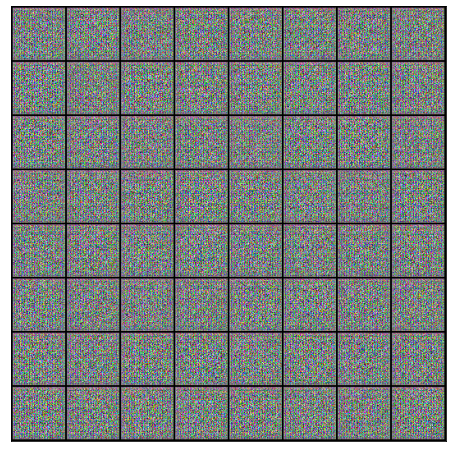

In [14]:
xb = torch.randn(BATCH_SIZE, LATENT_DIMS, 1, 1, device="cpu") # random latent tensors
fake_images = Generator()(xb)
show_images(fake_images.cpu().detach())

## Discriminator network

In [15]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # INPUT: (BATCH_SIZE, IMG_CHANNELS, IMG_SIZE, IMG_SIZE)

        self.conv1 = nn.Conv2d(in_channels=IMG_CHANNELS, out_channels=CAPACITY_D, kernel_size=4, stride=2, padding=1, bias=False)
        self.conv2 = nn.Conv2d(in_channels=CAPACITY_D, out_channels=CAPACITY_D*2, kernel_size=4, stride=2, padding=1, bias=False)
        self.conv3 = nn.Conv2d(in_channels=CAPACITY_D*2, out_channels=CAPACITY_D*4, kernel_size=4, stride=2, padding=1, bias=False)
        self.conv4 = nn.Conv2d(in_channels=CAPACITY_D*4, out_channels=CAPACITY_D*8, kernel_size=4, stride=2, padding=1, bias=False)
        self.conv5 = nn.Conv2d(in_channels=CAPACITY_D*8, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False)
        
        self.batch_norm_2 = nn.BatchNorm2d(CAPACITY_D*2)
        self.batch_norm_3 = nn.BatchNorm2d(CAPACITY_D*4)
        self.batch_norm_4 = nn.BatchNorm2d(CAPACITY_D*8)

        self.leaky_activation = nn.LeakyReLU(0.2, inplace=True)
        self.sigmoid_activation = nn.Sigmoid()

    
    def forward(self, xb):
        xb = self.conv1(xb)        
        xb = self.leaky_activation(xb)
    
        xb = self.conv2(xb)
        xb = self.batch_norm_2(xb)
        xb = self.leaky_activation(xb)
        
        xb = self.conv3(xb)
        xb = self.batch_norm_3(xb)
        xb = self.leaky_activation(xb)

        xb = self.conv4(xb)
        xb = self.batch_norm_4(xb)
        xb = self.leaky_activation(xb)

        xb = self.conv5(xb)
        xb = self.leaky_activation(xb)
        
        xb = xb.view(xb.size(0), -1)

        xb = self.sigmoid_activation(xb)
        return xb

In [16]:
test_discriminator_model = Discriminator()
test_discriminator_model.apply(weights_init)
test_discriminator_model = to_device(test_discriminator_model, device)
summary(test_discriminator_model, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]         131,072
       BatchNorm2d-4          [-1, 128, 16, 16]             256
         LeakyReLU-5          [-1, 128, 16, 16]               0
            Conv2d-6            [-1, 256, 8, 8]         524,288
       BatchNorm2d-7            [-1, 256, 8, 8]             512
         LeakyReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-10            [-1, 512, 4, 4]           1,024
        LeakyReLU-11            [-1, 512, 4, 4]               0
           Conv2d-12              [-1, 1, 1, 1]           8,192
        LeakyReLU-13              [-1, 1, 1, 1]               0
          Sigmoid-14                   

In [17]:
test_= torch.randn(1, 3, 64, 64, device=device)
test_discriminator_model(test_).shape

torch.Size([1, 1])

# Training Setup

In [18]:
def training_generator(generator, discriminator, optimizer_g):

    optimizer_g.zero_grad()

    targets = torch.ones(BATCH_SIZE, 1, device=device)

    # Generate fake images
    latent = torch.randn(BATCH_SIZE, LATENT_DIMS, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    loss = F.binary_cross_entropy(preds, targets)
    
    loss.backward()

    # Update generator weights
    optimizer_g.step()
    
    return loss.item()    

In [19]:
def training_discriminator(generator, discriminator, real_images, optimizer_d):
    optimizer_d.zero_grad()
    
    inp_batch_size = real_images.size(0)
    # Pass real images through discriminator

    # PART 1: D(x)
    real_targets = torch.full((inp_batch_size, 1), real_label, device=device)  # saves memory # BATCH_SIZE, 1 -> 1
    real_preds = discriminator(real_images)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    
    real_loss.backward()

    real_score = torch.mean(real_preds).item() # D_x
    
    # ------------------------------------------
    # PART 2: 1 - D_G_z

    # Generate fake images
    latent = torch.randn(inp_batch_size, LATENT_DIMS, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = real_targets.fill_(fake_label) # saves memory # BATCH_SIZE, 1 -> 0

    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)

    fake_loss.backward()

    fake_score = torch.mean(fake_preds).item() # D_G_z1

    # Update discriminator weights
    loss = real_loss + fake_loss

    
    optimizer_d.step()
    
    return loss.item(), real_score, fake_score

# Training

In [20]:
sample_dir = 'generated'
!rm -rf {sample_dir}

os.makedirs(sample_dir)

In [21]:
# fixed latents for visualizing progress

fixed_latents = torch.randn(64, LATENT_DIMS, 1, 1, device=device)

Saving generated-images-0000.png


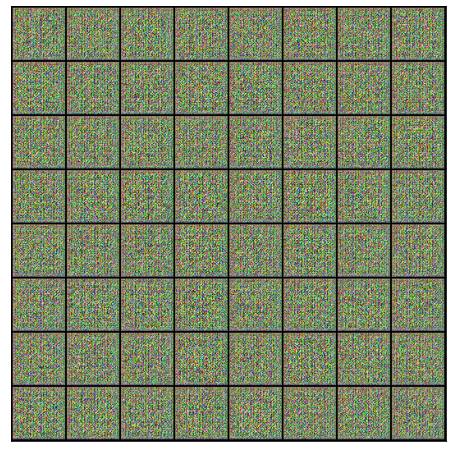

In [22]:
save_samples(0, to_device(Generator(), device), fixed_latents, show=True, verbose=True)

In [23]:
def fit(generator, discriminator, epochs, lr):

    torch.cuda.empty_cache()

    generator_loss = []
    discriminator_loss = []
    generator_score = []
    discriminator_score = []
    
    # create optimizers 
    optimizer_generator = torch.optim.Adam(generator.parameters(),
                                            lr=lr,
                                            betas=(BETA1, BETA2))
    
    optimizer_discriminator = torch.optim.Adam(discriminator.parameters(),
                                            lr=lr,
                                            betas=(BETA1, BETA2))

    for epoch in range(epochs):

        # Losses & scores
        losses_d = []
        losses_g = []
        real_scores = []
        fake_scores = []

        for real_images, _ in data_loader:

            # train discriminator 
            
            loss_d, real_score, fake_score = training_discriminator(generator, 
                                                                    discriminator,
                                                                    real_images,
                                                                    optimizer_discriminator)

            # train generator
            loss_g = training_generator(generator, 
                                        discriminator,
                                        optimizer_generator)
            
            # save current batch metrics
            losses_d.append(loss_d)
            losses_g.append(loss_g)
            real_scores.append(real_score)
            fake_scores.append(fake_score)

        # calculate epoch metric from all the batches
        losses_d_mean = np.mean(np.array(losses_d))
        losses_g_mean = np.mean(np.array(losses_g))
        real_scores_mean = np.mean(np.array(real_scores))
        fake_scores_mean = np.mean(np.array(fake_scores))


        # for plotting
        discriminator_loss.append(losses_d_mean)
        generator_loss.append(losses_g_mean)
        discriminator_score.append(real_scores_mean)
        generator_score.append(fake_scores_mean)

        # Log losses & scores
        print(f"Epoch [{epoch+1:03}/{epochs}], loss_g: {losses_g_mean:.5f}, loss_d: {losses_d_mean:.5f}, real_score: {real_scores_mean:.5f}, fake_score: {fake_scores_mean:.5f}")
    
        # Save generated images
        with torch.no_grad():
            save_samples(epoch+1, generator, fixed_latents, show=False, verbose=False)
    
    return generator_loss, discriminator_loss, discriminator_score, generator_score

In [24]:
# Model Initialization and weights setup

generator_model = Generator()
generator_model.apply(weights_init)
generator_model = to_device(generator_model, device)

discriminator_model = Discriminator()
discriminator_model.apply(weights_init)
discriminator_model = to_device(discriminator_model, device)

In [25]:
history = fit(generator_model, discriminator_model, EPOCHS, LEARNING_RATE)

Epoch [001/15], loss_g: 1.42114, loss_d: 1.02577, real_score: 0.66879, fake_score: 0.37013
Epoch [002/15], loss_g: 1.26230, loss_d: 1.02447, real_score: 0.66824, fake_score: 0.37806
Epoch [003/15], loss_g: 1.25378, loss_d: 0.96550, real_score: 0.69788, fake_score: 0.36677
Epoch [004/15], loss_g: 1.32302, loss_d: 0.90232, real_score: 0.72182, fake_score: 0.34384
Epoch [005/15], loss_g: 1.37299, loss_d: 0.81390, real_score: 0.76350, fake_score: 0.32814
Epoch [006/15], loss_g: 1.46414, loss_d: 0.75791, real_score: 0.78148, fake_score: 0.30277
Epoch [007/15], loss_g: 1.52262, loss_d: 0.71681, real_score: 0.79605, fake_score: 0.28884
Epoch [008/15], loss_g: 1.61465, loss_d: 0.66892, real_score: 0.81224, fake_score: 0.27171
Epoch [009/15], loss_g: 1.70344, loss_d: 0.62954, real_score: 0.82250, fake_score: 0.25595
Epoch [010/15], loss_g: 1.74138, loss_d: 0.61340, real_score: 0.83102, fake_score: 0.24710
Epoch [011/15], loss_g: 1.94449, loss_d: 0.51621, real_score: 0.86118, fake_score: 0.21457

In [26]:
# log and plot metrics

losses_g, losses_d, real_scores, fake_scores = history

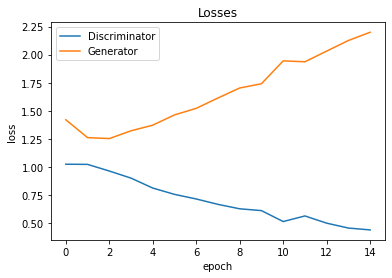

In [27]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
_ = plt.title('Losses')

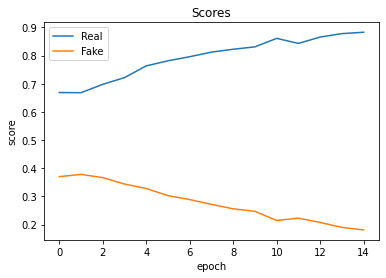

In [28]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
_ = plt.title('Scores')

In [29]:
# save model
torch.save(generator_model.to("cpu"), 'generator.pt')
torch.save(discriminator_model.to("cpu"), 'discriminator.pt')

In [30]:
import cv2

vid_fname = 'celebrity.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

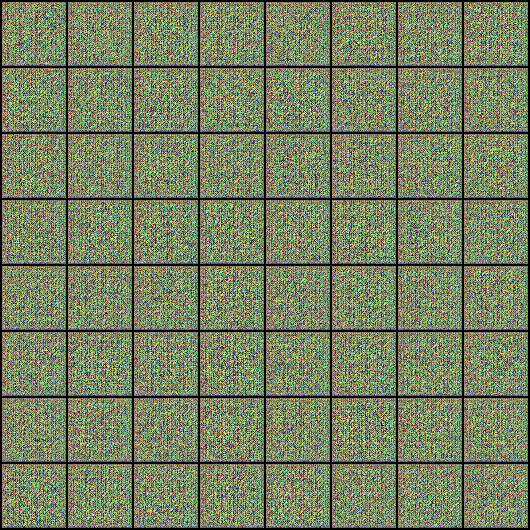

In [32]:
import imageio
import glob
from PIL import Image 
from numpy import asarray
import IPython.display as disp

generated_file = './celebrity.gif'


filenames = glob.glob('./generated/*.png')
filenames = sorted(filenames)
imgs = [asarray(Image.open(img)) for img in filenames]
imageio.mimsave(generated_file, imgs)

with open(generated_file,'rb') as file:
    disp.display(disp.Image(file.read()))